# QCoDeS Example with ZI UHF-LI
<img src="https://www.zhinst.com/sites/default/files/styles/zi01_product_gallery_zoom/public/uhfli_front.png?itok=8AgGdUFs", style="width: 600px"/>

## Table of Contents

* [Prerequisites](#prereq)
* [Basic Usage of the ZI UHF-LI](#basic)
  * [Signal Inputs](#sigins)
  * [Demodulators](#demods)
  * [Signal Outputs](#sigouts)
* [Using the Sweeper](#sweeper)
* [Using the Scope](#scope)


In [1]:
%matplotlib notebook
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import qcodes as qc
from qcodes.instrument_drivers.ZI.ZIUHFLI import ZIUHFLI

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

# Prerequisites <a class="anchor" id="prereq"></a>

It is necessary to download and install the ZI Lab One software. Additionally, both the data server and the web server must run, and a connection to the instrument must be instantiated (this can be done via the web interface). This example notebook makes no assumptions on what is connected to the instrument (but if you want nice data plots, go ahead and connect something interesting).

In [24]:
# Instantiate the QCoDeS instrument
zi = ZIUHFLI('ZIUHFLI', 'dev2235')

# Bind it to a QCoDeS station for later use (one should ALWAYS do this with instruments)
station = qc.Station(zi)

# Basic Usage of the ZI UHF-LI <a class="anchor" id="basic"></a>

Most of the "front panel" (i.e. the Web UI) `Lock-In` and `signal input` settings are available as parameters.

In [21]:
zi.oscillator2_freq.set(752.1e3)
print('Oscillator 2 has frequency: {:.0f} Hz'.format(zi.oscillator2_freq.get()))
zi.signal_input1_range(1)
zi.signal_input1_scaling(1)

Oscillator 2 has frequency: 752100 Hz


## Signal Inputs <a class="anchor" id="sigins"></a>

In [22]:
print('Available signal input settings:\n')
for param in [p for p in zi.parameters if 'signal_input1' in p]:
    print('  {}, {} ({})'.format(param, zi.parameters[param].label, zi.parameters[param].unit))

Available signal input settings:

  signal_input1_AC, AC coupling ()
  signal_input1_impedance, Input impedance ()
  signal_input1_scaling, Input scaling ()
  signal_input1_diff, Input signal subtraction ()
  signal_input1_range, Input range (V)


## Demodulators <a class="anchor" id="demods"></a>

In [5]:
print('Available demodulator settings:\n')
for param in [p for p in zi.parameters if 'demod1' in p]:
    print('  {}, {} ({})'.format(param, zi.parameters[param].label, zi.parameters[param].unit))

Available demodulator settings:

  demod1_streaming, Data streaming ()
  demod1_timeconstant, Filter time constant (s)
  demod1_samplerate, Sample rate (Sa/s)
  demod1_phaseshift, Phase shift (degrees)
  demod1_sinc, Sinc filter ()
  demod1_harmonic, Reference frequency multiplication factor ()
  demod1_signalin, Signal input ()
  demod1_order, Filter order ()
  demod1_trigger, Trigger ()


## Signal Outputs <a class="anchor" id="sigouts"></a>

In [6]:
print('Available signal output settings:\n')
for param in [p for p in zi.parameters if 'signal_output1' in p]:
    print('  {}, {} ({})'.format(param, zi.parameters[param].label, zi.parameters[param].unit))

Available signal output settings:

  signal_output1_enable, Enable signal output's amplitude. ()
  signal_output1_offset, Signal output offset (V)
  signal_output1_imp50, Switch to turn on 50 Ohm impedance ()
  signal_output1_on, Turn signal output on and off. ()
  signal_output1_range, Signal output range ()
  signal_output1_autorange, Enable signal output range. ()
  signal_output1_ampdef, Signal output amplitude's definition (V)
  signal_output1_amplitude, Signal output amplitude (V)


# Using the sweeper <a class="anchor" id="sweeper"></a>

The QCoDeS sweep is fully indendent of the GUI Sweep, meaning that parameters set in QCoDeS will not affect the GUI sweep and vice versa.

The sweeper settings are configured via a bunch of parameters, all named `sweeper_XXX`.
This configures the x-axis of the sweep as well as the sweep acquisition settings. To learn more about what a certain parameter does, it is sometimes helpful to print its `__doc__` attribute.

Which signals are **returned** by the sweeper is controlled by adding (removing) signals to (from) the sweep.

The sweep settings can be displayed with the `print_sweeper_settings` command.

Before the sweep can be performed, it must be built. 
This is done with the Sweep parameter, which is the parameter holding the sweep data.
Note that building the sweep may change some of the time constants, and in particular change the sweep time. In case of doubt, re-run `print_sweeper_settings`.

In [7]:
# Set up a sweep sweeping an internal oscillator frequency from 1 MHz to 5 MHz
# We want the sweeper to sweep linearly over 200 points
zi.sweeper_param('Osc 1 Frequency')
zi.sweeper_xmapping('lin')
zi.sweeper_start(1e6)
zi.sweeper_stop(10e6)
zi.sweeper_samplecount(100)
zi.sweeper_BWmode('fixed')
zi.sweeper_BW(250)
zi.sweeper_order(4)

In [8]:
# I wonder what the sweeper BWmode does...
print(zi.sweeper_BWmode.__doc__)


                                     For each sweep point, the demodulator
                                     filter bandwidth (time constant) may
                                     be either set automatically, be the
                                     current demodulator bandwidth or be
                                     a fixed number; the sweeper_BW
                                     parameter.
                                     

Parameter class:

* `name` sweeper_BWmode
* `label` Sweeper bandwidth control mode
* `unit` 
* `vals` <Enum: {'fixed', 'current', 'auto'}>


In [9]:
# Add three signals to the sweep, all measured on demodulator 1
zi.add_signal_to_sweeper(1, 'Xrms')
zi.add_signal_to_sweeper(1, 'Yrms')
zi.add_signal_to_sweeper(1, 'Rrms')

In [10]:
# Make sure that demodulator 1 is measuring what and as it should
zi.demod1_trigger('Continuous')
zi.demod1_signalin('Sig In 1')

In [11]:
# I wonder what kind of sweep we have made now...
zi.print_sweeper_settings()

ACQUISITION
    Sweeper bandwidth control mode: fixed ()
    Fixed bandwidth sweeper bandwidth (NEP): 50.0 ()
    Sweeper filter order: 1 ()
    Minimal no. of samples to average at each sweep point: 25 ()
    Minimal averaging time: 0.1 (s)
    Minimal settling time for the sweeper: 1e-06 (s)
    Sweep filter settling time: 4.605170185988091 (dim. less.)
HORISONTAL
    Start value of the sweep: 1000000.0
    Stop value of the sweep: 10000000.0
    Units of sweep x-axis: Hz
    Length of the sweep (pts): 25
    Parameter to sweep (sweep x-axis): Osc 1 Frequency
    Sweep mode: Sequential
    Sweep timeout: 600
VERTICAL
    Signal 1: Demodulator 1: Xrms
    Signal 2: Demodulator 1: Yrms
    Signal 3: Demodulator 1: Rrms
DEMODULATORS
    Demodulator 1: Filter time constant: 0.000311 (s)
    Demodulator 1: Filter order: 4.000000 ()
    Demodulator 1: Sample rate: 1716.613770 (Sa/s)
META
    Expected sweep time: 0.9 (s)
    Sweep timeout: 600 (s)
    Sweep built and ready to execute: False

In [12]:
# Gee, that looks good! Note the last line, the sweep is NOT ready to execute.
zi.Sweep.build_sweep()
# Now it is!
zi.print_sweeper_settings()

ACQUISITION
    Sweeper bandwidth control mode: fixed ()
    Fixed bandwidth sweeper bandwidth (NEP): 250.0 ()
    Sweeper filter order: 4 ()
    Minimal no. of samples to average at each sweep point: 25 ()
    Minimal averaging time: 0.1 (s)
    Minimal settling time for the sweeper: 1e-06 (s)
    Sweep filter settling time: 9.998049677807453 (dim. less.)
HORISONTAL
    Start value of the sweep: 1000000.0
    Stop value of the sweep: 10000000.0
    Units of sweep x-axis: Hz
    Length of the sweep (pts): 100
    Parameter to sweep (sweep x-axis): Osc 1 Frequency
    Sweep mode: Sequential
    Sweep timeout: 600
VERTICAL
    Signal 1: Demodulator 1: Xrms
    Signal 2: Demodulator 1: Yrms
    Signal 3: Demodulator 1: Rrms
DEMODULATORS
    Demodulator 1: Filter time constant: 0.000311 (s)
    Demodulator 1: Filter order: 4.000000 ()
    Demodulator 1: Sample rate: 1716.613770 (Sa/s)
META
    Expected sweep time: 1.8 (s)
    Sweep timeout: 600 (s)
    Sweep built and ready to execute: Tru

In [13]:
# We can now execute the sweeper by simply invoking Sweep.get
# This returns a tuple with the signals we asked for
(X, Y, R) = zi.Sweep.get()

<IPython.core.display.Javascript object>


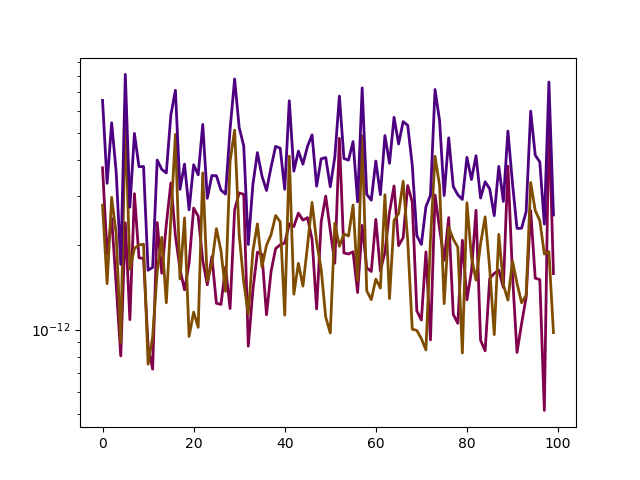

In [14]:
# This we may manually plot.
plt.figure()
plt.yscale('log')
plt.plot(X, lw=2, color=(0.5, 0, 0.3))
plt.plot(Y, lw=2, color=(0.5, 0.3, 0))
plt.plot(R, lw=2, color=(0.3, 0, 0.5))

In [15]:
# A more correct way to do this is to perform a proper QCoDeS measurement
sweepdata = qc.Measure(zi.Sweep).run()

Debug (100,) (100,)
Debug (100,) (100,)
Debug (100,) (100,)
DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-01/#011_{name}_11-49-47'
   <Type>   | <array_id>   | <array.name> | <array.shape>
   Measured | Hz           | Hz           | (100,)
   Measured | ZIUHFLI_Xrms | Xrms         | (100,)
   Measured | ZIUHFLI_Yrms | Yrms         | (100,)
   Measured | ZIUHFLI_Rrms | Rrms         | (100,)
acquired at 2017-03-01 11:49:51


# Using the scope <a class="anchor" id="scope"></a>

The scope is in a strange half-finished state, which is due to Zurich Instruments not yet shipping the full software package for the scope.

The QCoDeS scope is mostly synced with the GUI scope, with the averaging as a notable exeption. Please set ALL values using QCoDeS before performing a measurement.

## A word of caution

Many of the scope parameters depend on each other. We exemplify this now.

In [16]:
# Sampling rate, trace length, and trace duration all depend on each other
zi.scope_samplingrate('56.2 MHz')  # starting value for example

(SR, length, dur) = (zi.scope_samplingrate(), zi.scope_length(), zi.scope_duration())
print('Current scope settings: SR: {}, Length: {:d}, duration: {:.6f} ({})'.format(SR, int(length), dur, zi.scope_duration.unit))

# Now we change the 
zi.scope_duration(10e-3)
# The driver has now updated the length behind the scenes, so that the internal QCoDeS length matches what a new
# query will return
print('The length is {}, {}'.format(zi.scope_length.get_latest(), zi.scope_length.get()))

# Similarly if we change the number of points to half of the current value
oldN = zi.scope_length.get_latest()
zi.scope_length(int(oldN/2))
print('The duration is {}, {} and the length is {}'.format(zi.scope_duration.get_latest(),
                                                           zi.scope_duration.get(),
                                                           zi.scope_length.get()))

# Finally, note that changing the sampling rate does not change the length, but the duration
zi.scope_samplingrate('28.1 MHz')
print('Finally, length: {} points, duration : {} (s)'.format(zi.scope_length.get_latest(), zi.scope_duration.get_latest()))

Current scope settings: SR: 56.2 MHz, Length: 7030, duration: 0.000125 (s)
The length is 562000, 562000
The duration is 0.005, 0.005 and the length is 281000
Finally, length: 281000 points, duration : 0.01 (s)


## Setting up a scope measurement

In [16]:
# You must define at least everything. Here we go through the GUI settings one-by-one.

# THE CONTROL TAB
# Horisontal
zi.scope_mode.set('Time Domain')
zi.scope_samplingrate.set('7.03 MHz')
zi.scope_duration.set(1e-3)  # seconds
# Vertical
zi.scope_channel1_input.set('Signal Input 1')
zi.scope_channel2_input.set('Signal Input 2')
zi.scope_channels.set(3)  # 1: Chan1 only, 2: Chan2 only, 3: Chan1 + Chan2
zi.scope_average_weight(3)  # Number of averages

# THE TRIG TAB
# Trigger
zi.scope_trig_enable.set('ON')
zi.scope_trig_signal.set('Signal Input 2')
zi.scope_trig_slope.set('Rise')
zi.scope_trig_level.set(20e-3)  # Volts if the input is volts
zi.scope_trig_hystmode.set('absolute')
zi.scope_trig_hystabsolute.set(3e-3)  # Volts if the input is volts
zi.scope_trig_gating_enable.set('OFF')
zi.scope_trig_gating_source.set('Trigger In 4 Low')
zi.scope_trig_holdoffmode.set('s')  # QCoDeS currently does not support a holdoff in events. Ask William why. 
zi.scope_trig_holdoffseconds.set(2e-5)
zi.scope_trig_reference.set(0)  # Sets the reference for the delay in percent of the trace duration, i.e. 0 is at the trigger
zi.scope_trig_delay.set(1e-4)  # Sets the delay for the acquisition
# Segments (NB: Requires purchase of the DIG upgrade)
zi.scope_segments.set('ON')
zi.scope_segments_count.set(5)

In [17]:
# Just like the sweeper, the scope must be prepared for a measurement.
print('Is the scope ready? -{}'.format(zi.scope_correctly_built))

# Then the scope must be prepared for the measurement
zi.Scope.prepare_scope()

#
print('How about now? Can the scope be run? -{}'.format(zi.scope_correctly_built))

# And data can be pulled out with the get command
data = zi.Scope.get()

Is the scope ready? -False
How about now? Can the scope be run? -True


<IPython.core.display.Javascript object>


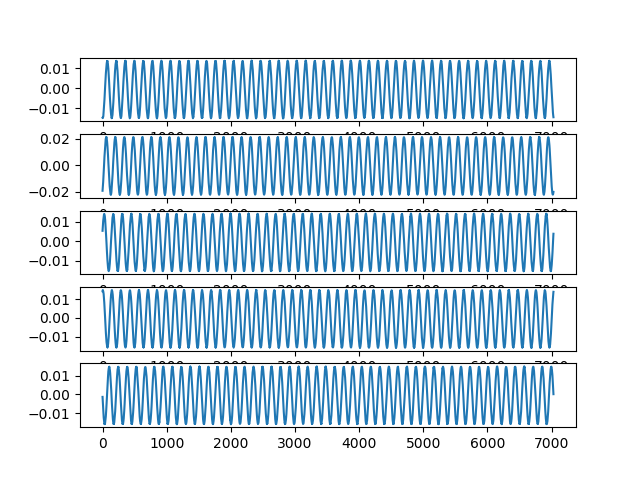

<IPython.core.display.Javascript object>


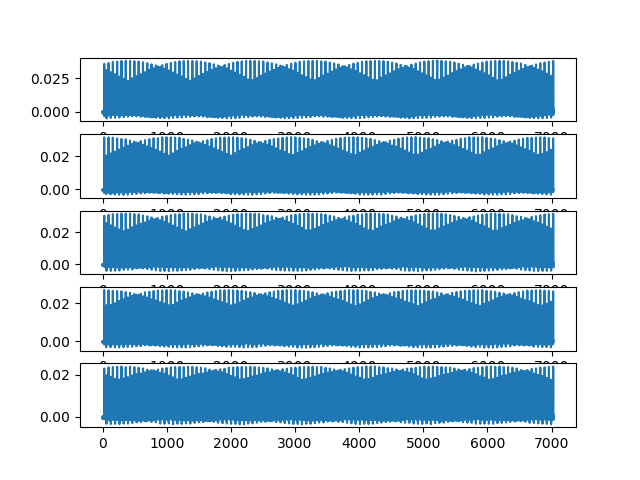

In [18]:
# And here is a small plotter

for chandata in data:
    if chandata is not None:
        fig, axs = plt.subplots(len(chandata), 1)
        for ind, ax in enumerate(axs):
            ax.plot(chandata[ind, :])

In [19]:
# But it is strongly encouraged to use measure with QCoDeS rather than by using the .get method directly.

scopedata = qc.Measure(zi.Scope).run()

Debug (5,) (5,)
Debug (5, 7030) (5, 7030)
Debug (5,) (5,)
Debug (5, 7030) (5, 7030)
DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-01/#012_{name}_11-57-04'
   <Type>   | <array_id>        | <array.name> | <array.shape>
   Measured | Time              | Time         | (5, 7030)
   Measured | ZIUHFLI_Sig. In 1 | Sig. In 1    | (5, 7030)
   Measured | ZIUHFLI_Sig. In 2 | Sig. In 2    | (5, 7030)
acquired at 2017-03-01 11:57:05


In [12]:
zi.daq.getDouble('/dev2235/demods/0/value')

RuntimeError: ZIAPINotFoundException with status code: 16387. Value or Node not found

In [23]:
zi.close()